In [1]:
import sys
sys.path.append('..')

In [16]:
import torch

import numpy as np

import models
import custom_transforms
from datasets.sequence_folders import SequenceFolder
from radar_eval.eval_utils import RadarEvalOdom
import conversions as tgm

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'TITAN V'

In [4]:
weights_pose = torch.load("../checkpoints/resnet50_depth_256/02-15-20-41/exp_pose_checkpoint.pth.tar")
pose_net = models.PoseResNet(18).to(device)
pose_net.load_state_dict(weights_pose['state_dict'], strict=False)
pose_net.eval()

PoseResNet(
  (encoder): ResnetEncoder(
    (encoder): ResNetMultiImageInput(
      (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [5]:
# Data loading code
mean, std = 11.49, 16.46 #robotcar
# mean, std = 119.4501, 6.5258 # Calculated over all dataset
normalize = custom_transforms.Normalize(mean=mean, std=std)

# train_transform = custom_transforms.Compose([
#     custom_transforms.RandomHorizontalFlip(),
#     custom_transforms.RandomScaleCrop(),
#     custom_transforms.ArrayToTensor(),
#     normalize
# ])

ds_transform = custom_transforms.Compose([custom_transforms.ArrayToTensor(), normalize])

k=1
val_set = SequenceFolder(
        '/mnt/datasets/yasin/robotcar',
        transform=ds_transform,
        seed=12344,
        train=False,
        sequence_length=3,
        skip_frames=k,
        dataset='driving'
    )

val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=2, shuffle=False,
        num_workers=2, pin_memory=True)

In [8]:
vo_eval = RadarEvalOdom('/mnt/datasets/yasin/records2-23mart2020/vicon-data-subsampled/vicon-gt-test1.csv')

In [6]:
def compute_pose_with_inv(pose_net, tgt_img, ref_imgs):
    poses = []
    poses_inv = []
    for ref_img in ref_imgs:
        poses.append(pose_net(tgt_img, ref_img))
        poses_inv.append(pose_net(ref_img, tgt_img))

    return torch.stack(poses), torch.stack(poses_inv)

In [90]:
all_poses = []
all_inv_poses = []

with torch.no_grad():
    for i, (tgt_img, ref_imgs) in enumerate(val_loader):
        #(tgt_img, ref_imgs) = val_it.next()

        tgt_img = tgt_img.to(device)
        ref_imgs = [img.to(device) for img in ref_imgs]

        poses, poses_inv = compute_pose_with_inv(pose_net, tgt_img, ref_imgs)

        all_poses.append(poses)
        all_inv_poses.append(poses_inv)

        # gc.collect()
        # torch.cuda.empty_cache()
    

In [91]:
print(len(all_poses))

1125


In [103]:
def getTraj(all_poses, all_inv_poses, k):
    """Convert the predicted poses to absolute trajectory. Each prediction in inputs is the relative pose for a sequence of [src_p, tgt, src_n].
    We form a trajectory from a chained sequence with k skip frames, e.g. [k, 2*k, 3*k, ..., N]. We shift the sequence by {i:i<k} to evaluate the full prediction.

    Args:
        all_poses (list): Predicted relative pose values for each src-to-tgt pair. List of torch.Tensor objects size [seq_length, B, 6]. rtvec=[rx, ry, rz, tx, ty, tz]
        all_inv_poses (list): Predicted relative pose values for each tgt-to-src pair. List of torch.Tensor objects.
        k (int): Skip frames. rtvec=[rx, ry, rz, tx, ty, tz]

    Returns:
        torch.Tensor: Backward and forward predicted trajectories
    """

    # pred = torch.zeros(self.gt.size(), dtype=self.gt.dtype, device = self.gt.device)
    all_poses_t = torch.cat(all_poses, 1) # [seq_length, N, 6]
    all_inv_poses_t = torch.cat(all_inv_poses, 1) # [seq_length, N, 6]
    
    #all_poses_t[:,:,0]=0.0
    #all_poses_t[:,:,1]=0.0
    #all_poses_t[:,:,5]=0.0

    N = all_poses_t.shape[1] #len(all_poses) # number of sequences

    i=0
    # for i in range(k):
    idx = torch.arange(i, N, k)
    
    # Previous src
    # TODO: Şimdilik forward pose alalım. ileride (forward-backward)/2 olmalı
    # b_pose = (all_poses_t[0, idx] - all_inv_poses_t[0, idx])/2 # (src2tgt + inv(tgt2src))/2 [n,6]
    b_pose = all_poses_t[0, idx] #src2tgt [n,6]
    b_pose = -b_pose # tgt2src [n,6]
    b_pose = tgm.rtvec_to_pose(b_pose) # tgt2src [n,4,4]
    # b_pose = tgm.inv_rigid_tform(b_pose) # tgt2src [n,4,4]
    
    # b_inv_pose = tgm.rtvec_to_pose(all_inv_poses_t[0, idx]) # inv(src2tgt) [n,4,4]            
    b_pose = rel2abs_traj(b_pose) # [n,4,4]
    # b_pose = b_pose.cumsum(dim=0) # [n,6] 

    # Next src
    # f_pose = tgm.rtvec_to_pose(all_poses_t[1, idx]) # tgt2src [n,4,4]
    # f_inv_pose = tgm.rtvec_to_pose(all_inv_poses_t[1, idx]) # inv(tgt2src) [n,4,4]
    # f_inv_pose = tgm.inv_rigid_tform(f_inv_pose) # inv(inv(tgt2src)) [n,4,4]
    # f_pose = (f_pose + f_inv_pose)/2 # (tgt2src + inv(inv(tgt2src)))/2 [n,4,4]
    # f_pose = rel2abs_traj(f_pose)
    # f_pose = (all_poses_t[1, idx] - all_inv_poses_t[0, idx])/2 # (src2tgt + inv(tgt2src))/2 [n,6]
    f_pose = all_poses_t[1, idx] #src2tgt [n,6]
    # f_pose = -f_pose # tgt2src [n,6]
    # f_pose = f_pose.cumsum(dim=0) # [n,6]
    f_pose = tgm.rtvec_to_pose(f_pose) # src2tgt [n,4,4]
    f_pose = rel2abs_traj(f_pose) # [n,4,4]
    # end for

    f_xyz = f_pose[:,:3,3]
    b_xyz = b_pose[:,:3,3]
    return b_xyz.squeeze(), f_xyz.squeeze()

def rel2abs_traj_old(rel_pose):
    """Convert a given relative pose sequences to absolute pose sequences.

    Args:
        rel_pose (torch.Tensor): Relative pose sequence in the form of homogenous transformation matrix. Shape: [N,4,4]

    Returns:
        torch.Tensor: Absolute pose sequence in the form of homogenous transformation matrix. Shape: [N,4,4]
    """

    abs_pose = rel_pose.clone()
    for i in range(1,abs_pose.shape[0]):
        abs_pose[i] = abs_pose[i] @ abs_pose[i-1]

    return abs_pose

def rel2abs_traj(rel_pose):
    """Convert a given relative pose sequences to absolute pose sequences.

    Args:
        rel_pose (torch.Tensor): Relative pose sequence in the form of homogenous transformation matrix. Shape: [N,4,4]

    Returns:
        torch.Tensor: Absolute pose sequence in the form of homogenous transformation matrix. Shape: [N,4,4]
    """
    global_pose = torch.eye(4).to(device)
    abs_pose = torch.zeros_like(rel_pose)    
    for i in range(rel_pose.shape[0]):
        global_pose = global_pose @ rel_pose[i]
        abs_pose[i] = global_pose

    return abs_pose


In [104]:
b_pred_xyz, f_pred_xyz = getTraj(all_poses, all_inv_poses, k)

In [105]:
print(f_pred_xyz.shape)

torch.Size([2249, 3])


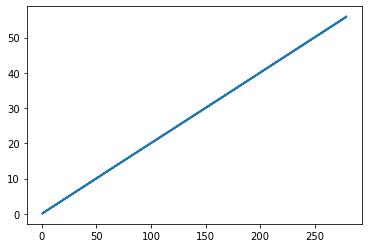

In [106]:
%matplotlib inline
plt.plot(f_pred_xyz[:,0].cpu().numpy(), f_pred_xyz[:,1].cpu().numpy())

# All pose analysis

In [96]:
all_poses_t = torch.cat(all_poses, 1) # [seq_length, N, 6]
all_inv_poses_t = torch.cat(all_inv_poses, 1) # [seq_length, N, 6]

In [97]:
print(all_poses_t.shape)

torch.Size([2, 2249, 6])


In [98]:
print(all_poses_t[0,:5])
print(all_inv_poses_t[0,:5])

tensor([[-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477]],
       device='cuda:0')
tensor([[-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477]],
       device='cuda:0')


In [15]:
N = all_poses_t.shape[1]

In [19]:
ate_bs = []
ate_fs = []

i=0
#for i in range(k):

idx = torch.arange(i, N, k)
            


In [22]:
print(all_poses_t[0, 0])

tensor([ 0.0314, -0.0452,  0.0081,  0.0153,  0.0062,  0.0026], device='cuda:0')


In [30]:
# Previous src
b_pose = all_poses_t[1, idx]


In [31]:
print(b_pose.shape)
print(b_pose[0])

torch.Size([98, 6])
tensor([ 0.0220, -0.0847,  0.0087,  0.0214,  0.0090,  0.0085], device='cuda:0')


In [32]:
b_pose = b_pose.cumsum(dim=0) # [n,6]

In [33]:
print(b_pose.shape)
print(b_pose[0])

torch.Size([98, 6])
tensor([ 0.0220, -0.0847,  0.0087,  0.0214,  0.0090,  0.0085], device='cuda:0')


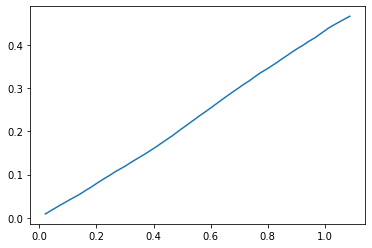

In [34]:
%matplotlib inline
plt.plot(b_pose[:,3].cpu().numpy(), b_pose[:,4].cpu().numpy())

# tgm tests

In [81]:
f_pose = torch.Tensor([
    [0,0,0,0,0,0],
    [0,0,0,2.0,0,0],
    [0,0,0,0,2,0],
    [0,0,1.57,0,0,0],
    [0,0,0,0,2,0]    
])

In [82]:
f_pose = tgm.rtvec_to_pose(f_pose)
f_pose = rel2abs_traj2(f_pose) # [n,4,4]

In [83]:
f_xyz = f_pose[:,:3,3]
print(f_xyz)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 2.0000e+00, 0.0000e+00],
        [2.0000e+00, 2.0000e+00, 0.0000e+00],
        [1.7881e-06, 2.0016e+00, 0.0000e+00]])


Text(0.5, 0, 'x')

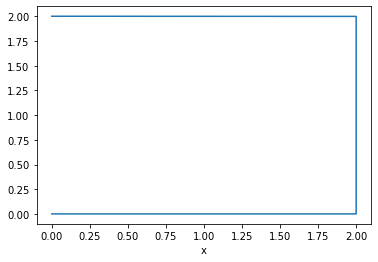

In [84]:
%matplotlib inline
plt.plot(f_xyz[:,0].cpu().numpy(), f_xyz[:,1].cpu().numpy())
plt.xlabel('x')